# Context :

## Mental Arithmetic EEG Dataset (36 subjects)

**Source Kaggle + PhysioNet (BIDS format)**

Objectif du dataset
Étudier les modifications de l’activité cérébrale (via EEG) lors de tâches cognitives impliquant une charge mentale élevée (séries de soustractions mentales). Ce dataset est utile pour :

- **la détection de stress cognitif**
- **la classification d'état mental (repos vs activité mentale)**
- les modèles de charge mentale ou de BCI (interfaces cerveau-machine)
- **la génération de connectomes EEG (cohérence, wPLI, etc.)**

## Méthode expérimentale
| Élément                     | Détail                                                                 |
|----------------------------|------------------------------------------------------------------------|
| Nombre de sujets            | 36 (étudiants en biologie / psychologie, âge moyen : 18,6 ans)         |
| Périodes enregistrées       | 3 minutes de repos + 1 minute d’activité mentale                       |
| Tâche cognitive             | Soustraction mentale de 2 nombres (ex : 3141 - 42)                     |
| Environnement               | Chambre sombre insonorisée, yeux fermés pendant l’enregistrement       |
| Position des électrodes     | Norme internationale 10/20  --> positions (Fp1, Fp2, F3, F4, F7, F8, T3, T4, ..., Pz) – 19 canaux au total |
| Matériel EEG                | Neurocom 23-channel system (XAI-MEDICA, Ukraine)                       |
| Fréquence d’échantillonnage | 500 Hz                                                                 |
| Filtrage                    | 0.5–45 Hz + notch 50 Hz + ICA (=Analyse en Composantes Indépendantes -> pour retirer les artéfacts)             |


# Description des fichiers (sur Kaggle)
https://www.kaggle.com/datasets/amananandrai/complete-eeg-dataset#

On dispose de 36 fichiers .csv, chacun correspondant à un sujet, avec :

- Colonnes : 19 canaux EEG standards (Fp1, Fp2, F3, ..., Pz)
- Lignes : ~30 000 points (soit 60 secondes à 500 Hz)


# Groupes de performance mentale
Les 36 sujets sont classés en deux groupes :

- G (Good counters, 24 sujets) : moyenne ≈ 21 opérations
- B (Bad counters, 12 sujets) : moyenne ≈ 7 opérations

Ce classement se trouve dans un fichier participants.tsv dans la version BIDS (PhysioNet), mais il n’est pas présent dans la version Kaggle. Il faudra l’ajouter à la main si nécessaire pour une tâche de classification supervisée.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, filtfilt
import seaborn as sns
import os
import networkx as nx

import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import plotly.graph_objects as go



# Lecture du dataset

In [13]:
csv_path = "../data/dataset/MATH_EEG/s00.csv"

columns = [
    "Fp1", "Fp2", "F3", "F4", "F7", "F8", "T3", "T4",
    "C3", "C4", "T5", "T6", "P3", "P4", "O1", "O2",
    "Fz", "Cz", "Pz"
]

df = pd.read_csv(csv_path, names=columns)

df.head()


,Fp1,Fp2,F3,F4,F7,F8,T3,T4,C3,C4,T5,T6,P3,P4,O1,O2,Fz,Cz,Pz
0,4.4760,-2.7403,-2.5017,0.095121,-7.0917,-0.42704,-2.5918,-3.3238,0.999500,0.87011,-0.080058,2.8075,-0.52398,1.93410,-3.7614,-1.1440,0.033687,2.7164,0.84831
1,1.2080,-3.3088,-4.4178,-0.529350,-8.5782,0.40699,-3.0996,-3.6005,-0.048363,-0.17258,-0.129650,3.2872,-1.06670,1.53570,-5.1933,-2.2263,-0.682180,4.8287,0.45261
2,-2.5460,-3.7083,-6.4109,-1.003300,-10.2200,1.87700,-3.6952,-3.8673,-1.132300,-1.32850,-0.094006,3.9756,-1.67430,1.12850,-6.5565,-3.0953,-1.284400,6.6513,-0.10393
3,-6.1871,-3.6804,-8.0297,-1.103100,-11.7210,4.01570,-4.2652,-4.0530,-1.984100,-2.36070,0.076473,4.8331,-2.22930,0.79364,-7.4787,-3.4209,-1.540900,7.6371,-0.74250
4,-9.1110,-3.0027,-8.8444,-0.651400,-12.7840,6.71770,-4.6708,-4.0965,-2.337200,-3.02550,0.401930,5.7805,-2.61450,0.58741,-7.6430,-2.9829,-1.248700,7.4512,-1.32640


# On trace les signaux

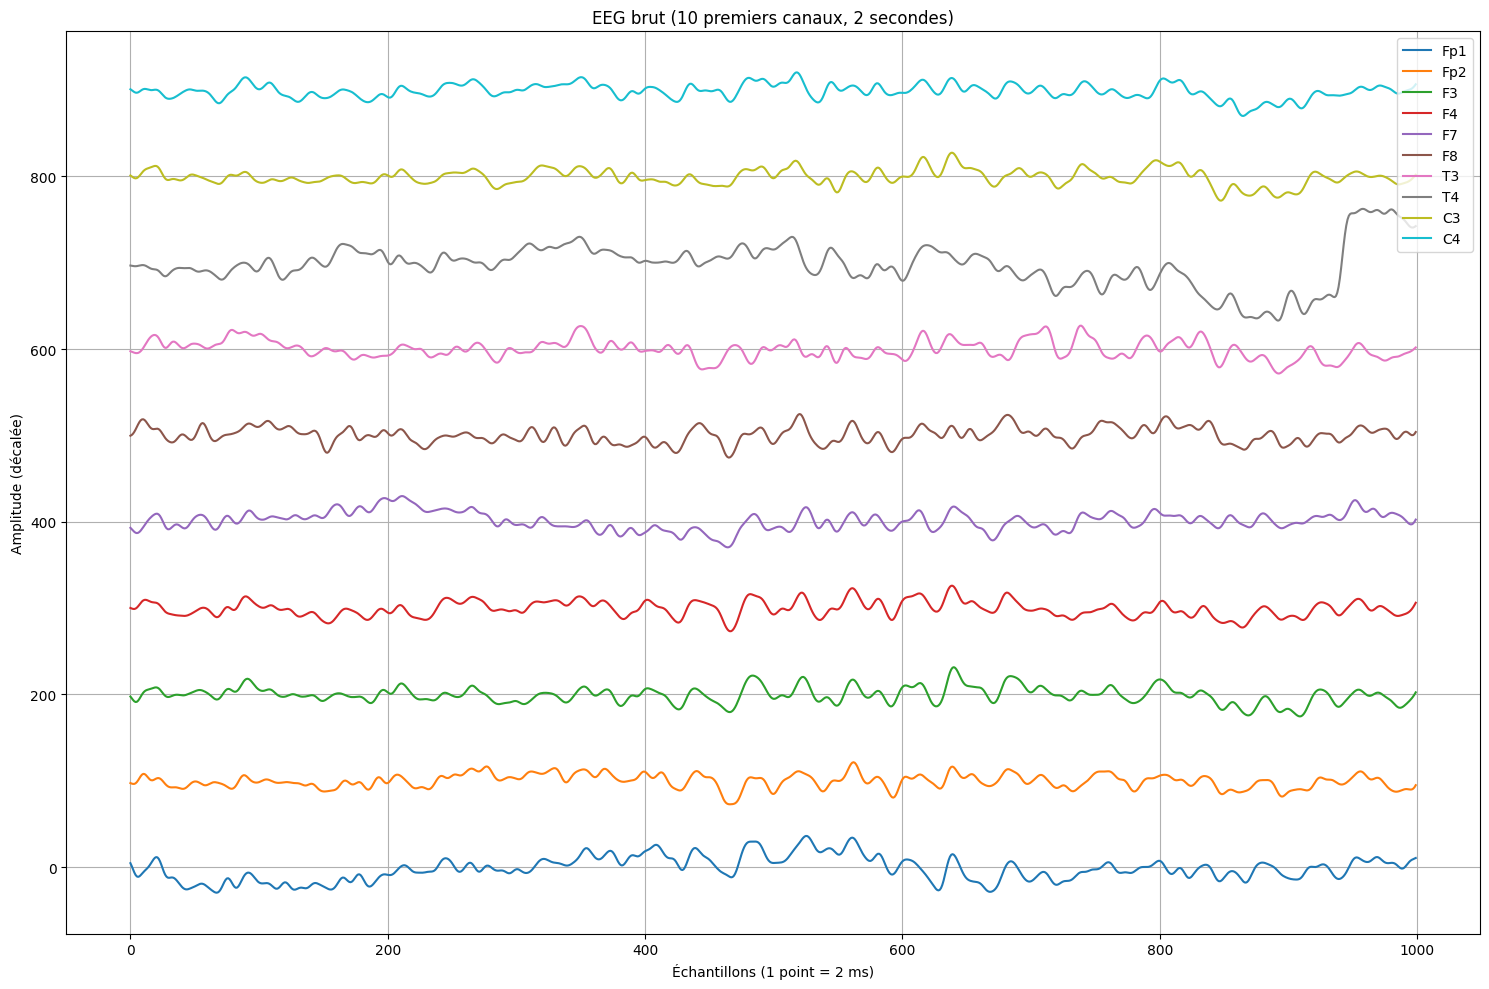

In [15]:
# Paramètres d'affichage
n_seconds = 2
sampling_rate = 500
n_points = n_seconds * sampling_rate

plt.figure(figsize=(15, 10))

# Afficher les 10 premiers canaux
for i, column in enumerate(df.columns[:10]):
    signal = df[column][:n_points]
    plt.plot(signal + i * 100, label=column)  # Décalage vertical pour lisibilité

plt.title("EEG brut (10 premiers canaux, 2 secondes)")
plt.xlabel("Échantillons (1 point = 2 ms)")
plt.ylabel("Amplitude (décalée)")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualization d'un canal individuel

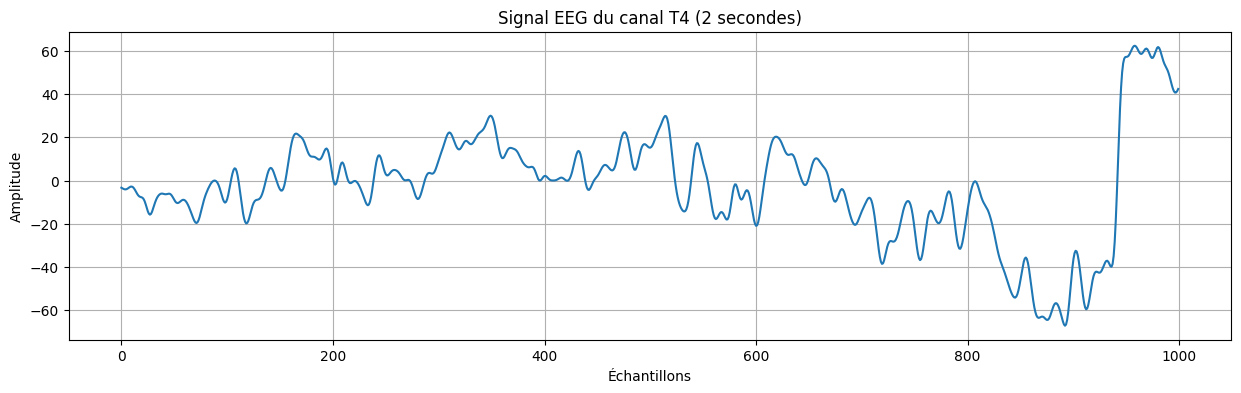

In [16]:
channel = "T4"  
signal = df[channel]

plt.figure(figsize=(15, 4))
plt.plot(signal[:1000])
plt.title(f"Signal EEG du canal {channel} (2 secondes)")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


# Commençons à voir comment faire un connectome ...
infos utiles : https://connectome-mapper-3.readthedocs.io/en/v3.2.0/api/generated/cmp.pipelines.functional.eeg.html

### Étape 1 : Filtrer nos signaux en bandes de fréquences comme dans l'article : 

| Bande | Plage de fréquence (Hz) | Interprétation                       |
| ----- | ----------------------- | ------------------------------------ |
| Delta | 0.5 – 4                 | Sommeil profond                      |
| Theta | 4 – 8                   | Sommeil léger, méditation            |
| Alpha | 8 – 13                  | Calme, relaxation                    |
| Beta  | 13 – 30                 | Activité mentale, alerte             |
| Gamma | 30 – 45 (ou 50)         | Cognition élevée, attention soutenue |

--> Filtre passe-bande Butterworth

In [17]:
sampling_rate = 500  # Hz

# ---- Fonction -----
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Applique un filtre passe-bande à un signal EEG.

    :param data: Signal EEG brut
    :param lowcut: Fréquence de coupure inférieure (Hz)
    :param highcut: Fréquence de coupure supérieure (Hz)
    :param fs: Fréquence d'échantillonnage (Hz)
    :param order: Ordre du filtre
    :return: Signal EEG filtré
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# ---- Application ----
channel = "T4"
signal = df[channel].values

# ---- Bandes de fréquence souhaitées ----
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 45)
}


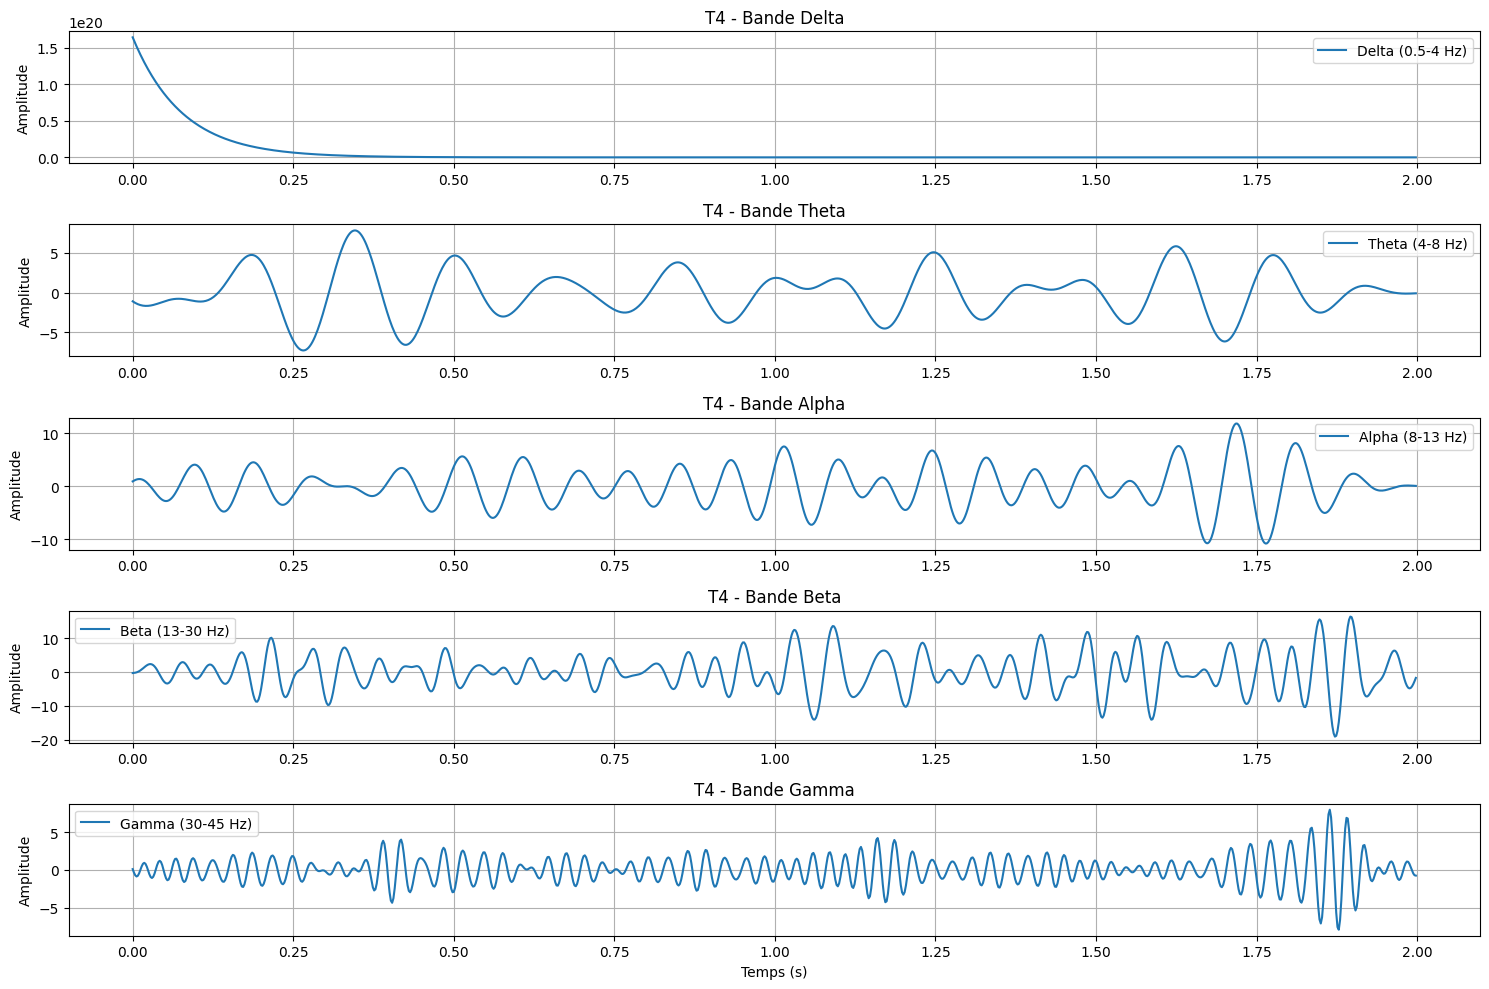

In [18]:
# ---- Visualisation du signal filtré par bande ----
n_seconds = 2
n_samples = n_seconds * sampling_rate
t = np.arange(n_samples) / sampling_rate

plt.figure(figsize=(15, 10))

for i, (band, (low, high)) in enumerate(bands.items()):
    filtered = bandpass_filter(signal[:n_samples], low, high, sampling_rate)
    plt.subplot(len(bands), 1, i + 1)
    plt.plot(t, filtered, label=f'{band} ({low}-{high} Hz)')
    plt.title(f'{channel} - Bande {band}')
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()

plt.xlabel("Temps (s)")
plt.tight_layout()
plt.show()

### Étape 2 : Construction d'une matrice de connectivité

À partir des signaux EEG filtrés dans une bande (ex : alpha), on veut construire une matrice 19×19 où chaque valeur représente le niveau de lien entre deux électrodes (canaux).

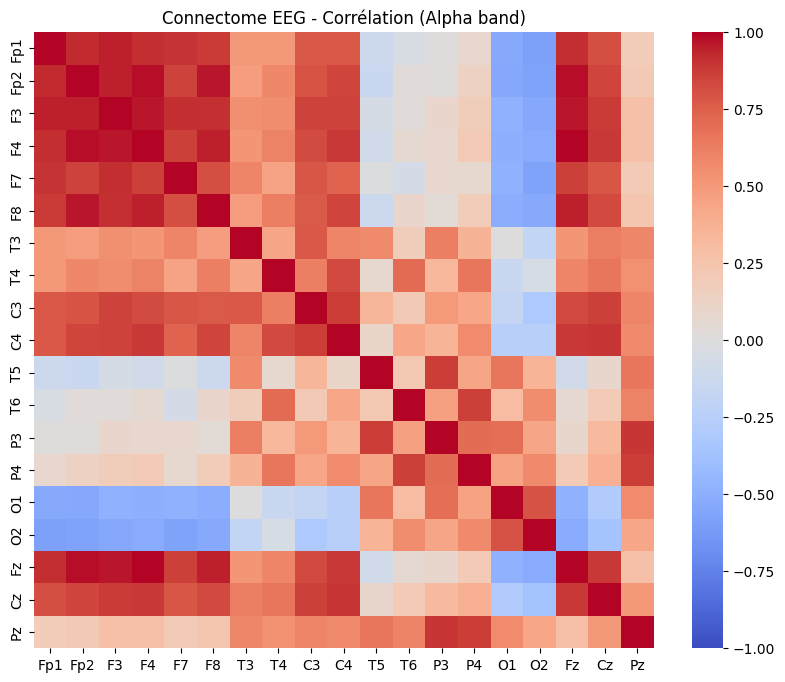

In [7]:
# ---- Paramètres ----
band_name = "Alpha"
lowcut, highcut = bands[band_name]
fs = 500
df_band = df.copy()

# ---- Application ----
for col in df.columns:
    df_band[col] = bandpass_filter(df[col].values, lowcut, highcut, fs)

# --- Calcul de la matrice de connectivité (corrélation de Pearson) ---
connectome = df_band.corr()

# ---- Affichage ----
plt.figure(figsize=(10, 8))
sns.heatmap(connectome, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title(f"Connectome EEG - Corrélation ({band_name} band)")
plt.show()


### Intéressant mais le visuel est bof...

In [8]:
# Créer un dossier de sortie
save_dir = "../data/connectomes/s00/"
os.makedirs(save_dir, exist_ok=True)

connectomes = {}  # pour stockage en mémoire si besoin

for band_name, (lowcut, highcut) in bands.items():
    df_filtered = df.copy()
    for col in df.columns:
        df_filtered[col] = bandpass_filter(df[col].values, lowcut, highcut, fs)

    # Matrice de corrélation
    conn_matrix = df_filtered.corr().to_numpy()
    connectomes[band_name] = conn_matrix

    # Sauvegarde en .npy
    save_path = os.path.join(save_dir, f"{band_name}_corr.npy")
    np.save(save_path, conn_matrix)

In [9]:
# Exemple pour le sujet s00 et bande Alpha
conn = np.load("../data/connectomes/s00/Alpha_corr.npy")  # shape (19, 19)
threshold = 0.5  # Corrélation minimale pour créer une arête

# Extraction des arêtes (seuillage)
edges = np.argwhere(np.abs(conn) > threshold)
edges = edges[edges[:, 0] != edges[:, 1]]

# Construction du Data object PyG
edge_index = torch.tensor(edges.T, dtype=torch.long)
edge_attr = torch.tensor([conn[i, j] for i, j in edges], dtype=torch.float)
x = torch.eye(conn.shape[0], dtype=torch.float)  # Features identitaires

data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


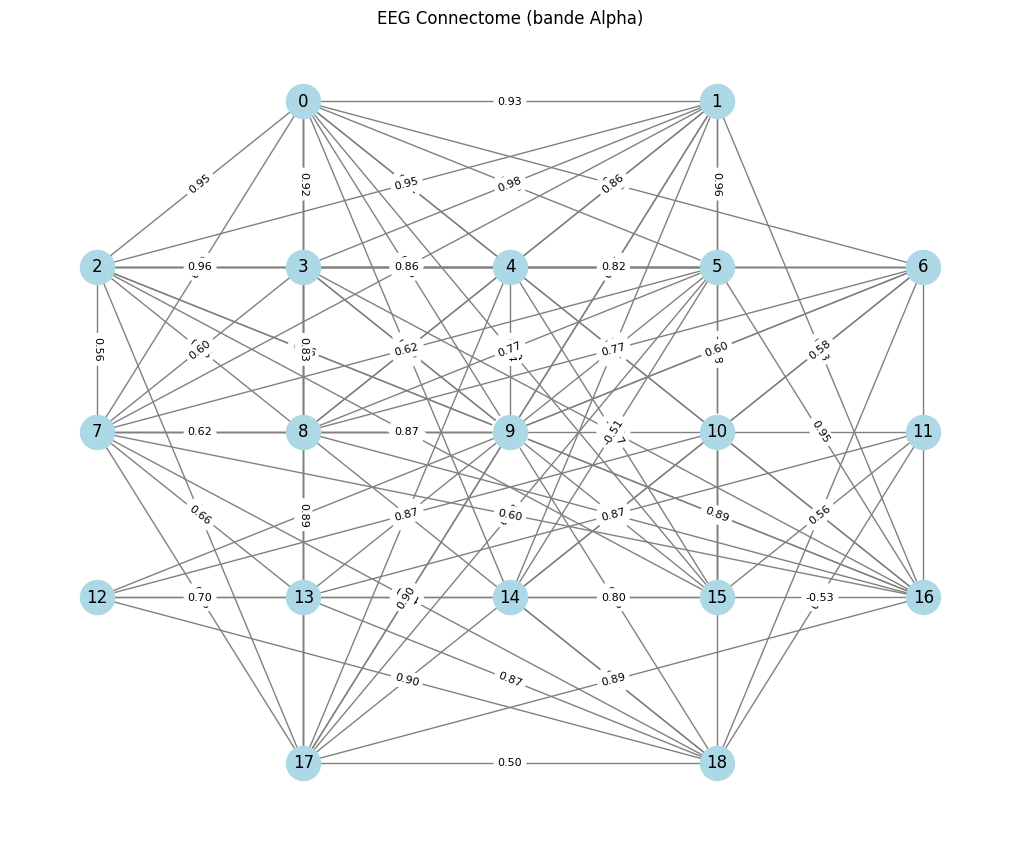

In [10]:
# Layout EEG standard 10-20
positions_1020 = {
    'Fp1': (-1, 2), 'Fp2': (1, 2), 'F7': (-2, 1), 'F3': (-1, 1), 'Fz': (0, 1), 'F4': (1, 1), 'F8': (2, 1),
    'T3': (-2, 0), 'C3': (-1, 0), 'Cz': (0, 0), 'C4': (1, 0), 'T4': (2, 0),
    'T5': (-2, -1), 'P3': (-1, -1), 'Pz': (0, -1), 'P4': (1, -1), 'T6': (2, -1),
    'O1': (-1, -2), 'O2': (1, -2)
}
labels = list(positions_1020.keys())
pos = {i: positions_1020[label] for i, label in enumerate(labels)}

# Convertir en graphe NetworkX
G = to_networkx(data, edge_attrs=["edge_attr"], to_undirected=True)

# Tracer
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=600)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d['edge_attr']:.2f}" for u, v, d in G.edges(data=True)}, font_size=8)
plt.title("EEG Connectome (bande Alpha)")
plt.axis('off')
plt.show()


In [11]:
edge_x, edge_y = [], []
for i, j in edge_index.T.numpy():
    x0, y0 = pos[i]
    x1, y1 = pos[j]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

node_x = [pos[i][0] for i in range(len(pos))]
node_y = [pos[i][1] for i in range(len(pos))]

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    marker=dict(size=20, color='lightblue'),
    text=labels, textposition="top center",
    hoverinfo='text'
)

fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='EEG Connectome interactif (bande Alpha)',
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                ))

fig.show()


### Pas top... À voir comment améliorer --> Go bosser la théorie